Loading and preprocessing data...
Engineering features...

Training model with optimal hyperparameters...

Class distribution after SMOTE:
Counter({'2': 18915, 'R': 18915, '1': 18915, '3': 18915, 'W': 18915})
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004129 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 94575, number of used features: 14
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from 

<Figure size 1200x800 with 0 Axes>

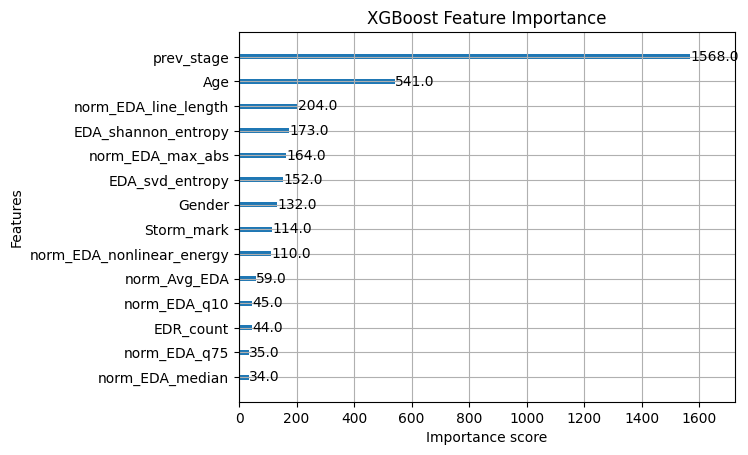


Detailed Classification Report (Merged N2/N3):
              precision    recall  f1-score   support

           1     0.3030    0.3012    0.3021       674
         2/3     0.9088    0.9028    0.9058      5002
           R     0.9017    0.9143    0.9080      2077
           W     0.7286    0.7325    0.7305      1473

    accuracy                         0.8343      9226
   macro avg     0.7105    0.7127    0.7116      9226
weighted avg     0.8342    0.8343    0.8342      9226



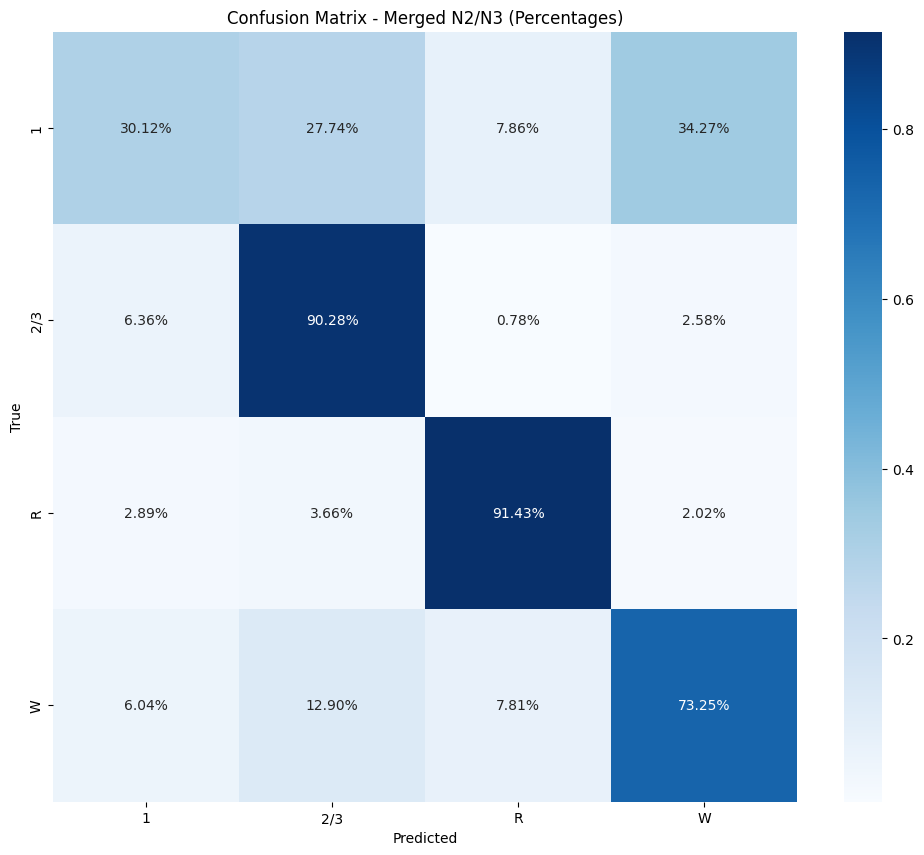

In [10]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from imblearn.over_sampling import SMOTE
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import xgboost as xgb
import lightgbm as lgb
from sklearn.ensemble import VotingClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
from collections import Counter
import joblib

# 1. Enhanced Data Loading with NaN Handling
def load_and_preprocess_data(features_dir):
    """Load and combine all feature files with proper patient IDs and label handling"""
    feature_files = glob.glob(os.path.join(features_dir, "Features_P*.csv"))
    dfs = []
    
    for file in feature_files:
        df = pd.read_csv(file)
        # Extract patient ID from filename
        patient_id = int(os.path.basename(file).split('_')[1][1:])
        df['patient_id'] = patient_id
        
        # Standardize REM sleep labels (convert all to 'R')
        df['Sleep_stage'] = df['Sleep_stage'].replace({'r': 'R'})
        
        # Ensure sleep stage is treated as string
        df['Sleep_stage'] = df['Sleep_stage'].astype(str)
        
        dfs.append(df)
    
    combined_df = pd.concat(dfs, ignore_index=True)
    combined_df.replace([np.inf, -np.inf], np.nan, inplace=True)
    
    return combined_df

# 2. Robust Feature Engineering with Imputation
def normalize_by_subject(df):
    """Normalize features within each subject with robust handling"""
    features_to_normalize = [
        'Avg_EDA', 'EDA_median', 'EDA_max_abs', 'EDA_q10', 'EDA_q75',
        'EDA_line_length', 'EDA_nonlinear_energy'
    ]
    
    for feat in features_to_normalize:
        df[f'norm_{feat}'] = df.groupby('patient_id')[feat].transform(lambda x: (x - x.median()) / (x.quantile(0.75) - x.quantile(0.25) + 1e-8))
    
    return df

def add_temporal_features(df):
    """Add temporal features with proper label encoding"""
    df = df.sort_values(['patient_id', 'Epoch_duration'])
    
    le = LabelEncoder()
    all_stages = pd.concat([df['Sleep_stage'], df['Sleep_stage'].shift(1)])
    le.fit(all_stages.dropna().unique())
    
    df['prev_stage'] = le.transform(df.groupby('patient_id')['Sleep_stage'].shift(1).fillna('W'))
    
    return df, le

def handle_missing_values(df, target_col=None):
    """Advanced missing value imputation"""
    if target_col and target_col in df.columns:
        target = df[target_col]
        features = df.drop(columns=[target_col])
    else:
        features = df.copy()
    
    imputer = IterativeImputer(max_iter=10, random_state=42)
    imputed_features = imputer.fit_transform(features)
    imputed_df = pd.DataFrame(imputed_features, columns=features.columns)
    
    if target_col and target_col in df.columns:
        imputed_df[target_col] = target.values
    
    return imputed_df

def merge_n2_n3_stages(y_true, y_pred, le):
    """Merge N2 and N3 stages in the results"""
    stage_names = le.inverse_transform(range(len(le.classes_)))
    n2_idx = np.where(stage_names == '2')[0][0]
    n3_idx = np.where(stage_names == '3')[0][0]
    
    y_true_merged = np.where(y_true == n3_idx, n2_idx, y_true)
    y_pred_merged = np.where(y_pred == n3_idx, n2_idx, y_pred)
    
    merged_classes = [c for c in stage_names if c != '3']
    merged_classes[merged_classes.index('2')] = '2/3'
    
    return y_true_merged, y_pred_merged, merged_classes

# 3. Enhanced Model Training with Optimal Hyperparameters
def train_evaluate_model(X, y, le):
    """Complete model training pipeline with optimal hyperparameters"""
    # Handle missing values
    data = X.copy()
    data['Sleep_stage'] = y
    if data.isna().any().any():
        data = handle_missing_values(data, target_col='Sleep_stage')
    
    X = data.drop(columns=['Sleep_stage'])
    y = data['Sleep_stage']
    
    # Calculate class weights
    class_counts = np.bincount(y)
    weights = len(y) / (len(class_counts) * class_counts)
    weight_map = {i: w for i, w in enumerate(weights)}
    
    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    # Apply SMOTE only to training data
    try:
        smote = SMOTE(random_state=42, sampling_strategy='not majority')
        X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
        print("\nClass distribution after SMOTE:")
        print(Counter(le.inverse_transform(y_train_res)))
    except Exception as e:
        print(f"\nSMOTE failed: {e}. Using original distribution with class weights.")
        X_train_res, y_train_res = X_train.copy(), y_train.copy()
    
    # OPTIMAL PARAMETERS FROM GRIDSEARCH
    xgb_params = {
        'objective': 'multi:softprob',
        'num_class': len(le.classes_),
        'max_depth': 3,          # From GridSearch
        'eta': 0.05,             # From GridSearch
        'subsample': 1.0,        # From GridSearch
        'colsample_bytree': 1.0, # Matches feature_fraction=1.0
        'gamma': 0.1,           # Default regularization
        'min_child_weight': 1,   # Sensitive to minority classes
        'eval_metric': ['mlogloss', 'merror'],
        'seed': 42
    }

    lgb_params = {
        'objective': 'multiclass',
        'num_class': len(le.classes_),
        'learning_rate': 0.01,   # From GridSearch
        'num_leaves': 15,        # From GridSearch
        'feature_fraction': 1.0, # From GridSearch
        'min_child_samples': 10, # Sensitive to small groups
        'reg_alpha': 0.1,
        'reg_lambda': 0.1,
        'class_weight': 'balanced'
    }

    # Create models with sample weights
    sample_weights = np.array([weight_map[c] for c in y_train_res])
    
    xgb_model = xgb.XGBClassifier(**xgb_params)
    xgb_model.fit(X_train_res, y_train_res, sample_weight=sample_weights)
    
    lgbm_model = lgb.LGBMClassifier(**lgb_params)
    lgbm_model.fit(X_train_res, y_train_res)
    
    # Create ensemble
    ensemble = VotingClassifier(
        estimators=[
            ('xgb', xgb_model),
            ('lgbm', lgbm_model)
        ],
        voting='soft'
    )
    ensemble.fit(X_train_res, y_train_res)
    
    # Predict and evaluate
    y_pred = ensemble.predict(X_test)
    
    print("\nDetailed Classification Report (Original Classes):")
    print(classification_report(y_test, y_pred, target_names=le.classes_, digits=4))
    
    # Feature Importance
    plt.figure(figsize=(12, 8))
    xgb.plot_importance(xgb_model, max_num_features=20)
    plt.title('XGBoost Feature Importance')
    plt.show()
    
    # Merged N2/N3 evaluation
    y_test_merged, y_pred_merged, merged_classes = merge_n2_n3_stages(y_test, y_pred, le)
    print("\nDetailed Classification Report (Merged N2/N3):")
    print(classification_report(y_test_merged, y_pred_merged, target_names=merged_classes, digits=4))
    
    # Confusion Matrix
    cm = confusion_matrix(y_test_merged, y_pred_merged)
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm_percent, annot=True, fmt='.2%', cmap='Blues',
                xticklabels=merged_classes, yticklabels=merged_classes)
    plt.title('Confusion Matrix - Merged N2/N3 (Percentages)')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    
    return ensemble

# Main Execution
if __name__ == "__main__":
    # Load and preprocess data
    print("Loading and preprocessing data...")
    data = load_and_preprocess_data(
        r"C:\Users\LENOVO\OneDrive - American University of Beirut\FYP 2024-25 ECE\FYP_Fall_2024-2025\ML Implementation\XGBOOST_first_try\Features_with_entropy"
    )
    
    # Feature engineering
    print("Engineering features...")
    data, le = add_temporal_features(data)
    data = normalize_by_subject(data)
    data['Sleep_stage'] = le.transform(data['Sleep_stage'])
    
    # Feature selection
    feature_columns = [
        'norm_Avg_EDA', 'norm_EDA_median', 'norm_EDA_max_abs',
        'norm_EDA_q10', 'norm_EDA_q75', 'norm_EDA_line_length',
        'norm_EDA_nonlinear_energy', 'EDA_svd_entropy',
        'EDA_shannon_entropy', 'EDR_count', 'Storm_mark',
        'Age', 'Gender', 'prev_stage'
    ]
    
    X = data[feature_columns]
    y = data['Sleep_stage']
    
    # Train and evaluate
    print("\nTraining model with optimal hyperparameters...")
    ensemble = train_evaluate_model(X, y, le)
    
    # # Save model
    # joblib.dump(ensemble, 'optimized_sleep_stage_model.pkl')
    # print("\nOptimized model saved to 'optimized_sleep_stage_model.pkl'")

N1 optimized implementation

Loading and preprocessing data...
Engineering features...

Training model with N1-focused enhancements...
SMOTE failed: With over-sampling methods, the number of samples in a class should be greater or equal to the original number of samples. Originally, there is 18860 samples and 9141 samples are asked.. Using class weights only.


c:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:37:34] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001464

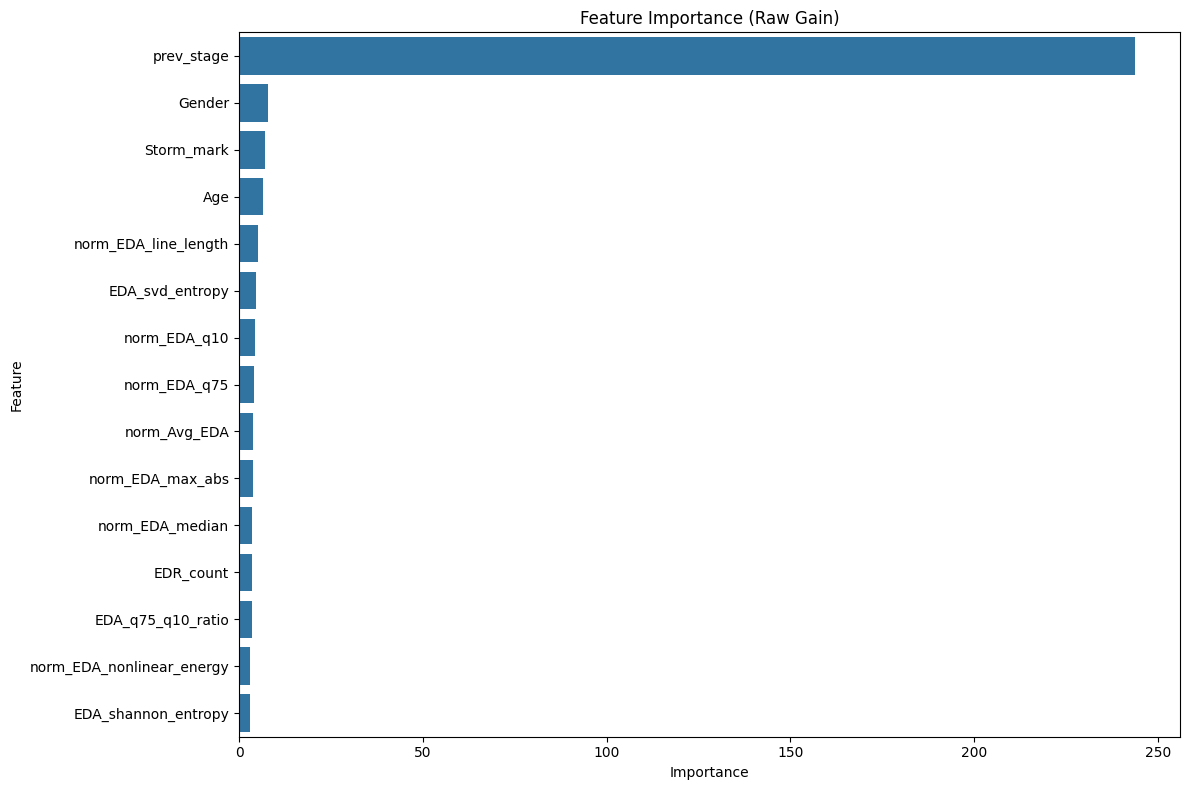

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1

Detailed Classification Report (Merged N2/N3):
              precision    recall  f1-score   support

           1     0.3142    0.3199    0.3170       669
         2/3     0.9038    0.9138    0.9088      4987
           R     0.9061    0.9136    0.9098      2060
           W     0.7472    0.7032    0.7245      1425

    accuracy                         0.8374      9141
   macro avg     0.7178    0.7126    0.7150      9141
weighted avg     0.8368    0.8374    0.8370      9141



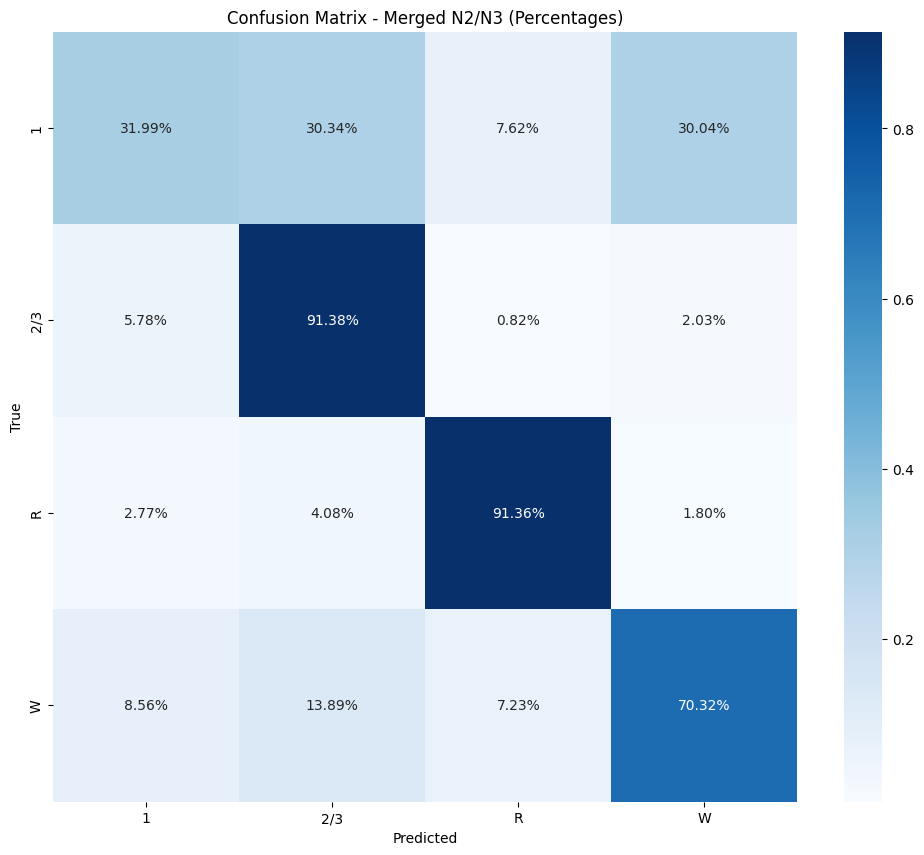

In [13]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from imblearn.over_sampling import SMOTE
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import xgboost as xgb
import lightgbm as lgb
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
from collections import Counter
import joblib
from sklearn.preprocessing import StandardScaler

# 1. Enhanced Data Loading with NaN Handling
def load_and_preprocess_data(features_dir):
    """Load and combine all feature files with proper patient IDs and label handling"""
    feature_files = glob.glob(os.path.join(features_dir, "Features_P*.csv"))
    dfs = []
    
    for file in feature_files:
        df = pd.read_csv(file)
        patient_id = int(os.path.basename(file).split('_')[1][1:])
        df['patient_id'] = patient_id
        df['Sleep_stage'] = df['Sleep_stage'].replace({'r': 'R'}).astype(str)
        dfs.append(df)
    
    combined_df = pd.concat(dfs, ignore_index=True)
    combined_df.replace([np.inf, -np.inf], np.nan, inplace=True)

    # Drop rows with any NaN values
    combined_df = combined_df.dropna()
    
    return combined_df

# 2. Robust Feature Engineering with N1-Specific Features
def normalize_by_subject(df):
    """Normalize features within each subject with robust handling"""
    features_to_normalize = [
        'Avg_EDA', 'EDA_median', 'EDA_max_abs', 'EDA_q10', 'EDA_q75',
        'EDA_line_length', 'EDA_nonlinear_energy'
    ]
    
    for feat in features_to_normalize:
        df[f'norm_{feat}'] = df.groupby('patient_id')[feat].transform(
lambda x: (x - x.median()) / (x.quantile(0.75) - x.quantile(0.25) + 1e-8))
    return df

def add_n1_specific_features(df):
    """Features known to help discriminate N1"""
    # N1 often has characteristic EDA patterns
    df['N1_EDA_pattern'] = ((df['norm_EDA_median'] > 0.5) & (df['norm_EDA_q75'] < 0.2))
    df['N1_EDA_pattern'] = df['N1_EDA_pattern'].astype(int)
    
    # Ratio features that help identify N1
    df['EDA_q75_q10_ratio'] = df['EDA_q75'] / (df['EDA_q10'] + 1e-8)
    return df

def add_temporal_features(df):
    """Add temporal features with proper label encoding"""
    df = df.sort_values(['patient_id', 'Epoch_duration'])
    le = LabelEncoder()
    all_stages = pd.concat([df['Sleep_stage'], df['Sleep_stage'].shift(1)])
    le.fit(all_stages.dropna().unique())
    df['prev_stage'] = le.transform(df.groupby('patient_id')['Sleep_stage'].shift(1).fillna('W'))
    return df, le

def handle_missing_values(df, target_col=None):
    """Advanced missing value imputation"""
    if target_col and target_col in df.columns:
        target = df[target_col]
        features = df.drop(columns=[target_col])
    else:
        features = df.copy()
    
    imputer = IterativeImputer(max_iter=10, random_state=42)
    imputed_features = imputer.fit_transform(features)
    imputed_df = pd.DataFrame(imputed_features, columns=features.columns)
    
    if target_col and target_col in df.columns:
        imputed_df[target_col] = target.values
    return imputed_df

def merge_n2_n3_stages(y_true, y_pred, le):
    """Merge N2 and N3 stages in the results"""
    stage_names = le.inverse_transform(range(len(le.classes_)))
    n2_idx = np.where(stage_names == '2')[0][0]
    n3_idx = np.where(stage_names == '3')[0][0]
    
    y_true_merged = np.where(y_true == n3_idx, n2_idx, y_true)
    y_pred_merged = np.where(y_pred == n3_idx, n2_idx, y_pred)
    
    merged_classes = [c for c in stage_names if c != '3']
    merged_classes[merged_classes.index('2')] = '2/3'
    return y_true_merged, y_pred_merged, merged_classes

# 3. N1-Focused Model Training
class N1FocusedEnsemble:
    """Custom ensemble that boosts N1 predictions"""
    def __init__(self, models, le, n1_index, boost_factor=2):
        self.models = models
        self.le = le
        self.n1_index = n1_index
        self.boost_factor = boost_factor
        
    def predict_proba(self, X):
        probas = [model.predict_proba(X) for model in self.models]
        avg_proba = np.mean(probas, axis=0)
        
        # Boost N1 probabilities
        avg_proba[:, self.n1_index] *= self.boost_factor
        # Renormalize
        return avg_proba / avg_proba.sum(axis=1)[:, np.newaxis]
        
    def predict(self, X):
        return np.argmax(self.predict_proba(X), axis=1)

def train_evaluate_model(X, y, le):
    # 1. PROPER DATA SPLITTING FIRST
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    # 2. MISSING VALUE IMPUTATION (after split!)
    imputer = IterativeImputer(max_iter=10, random_state=42)
    X_train = imputer.fit_transform(X_train)
    X_test = imputer.transform(X_test)

    # 3. SCALING
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # 4. APPLY SMOTE AFTER CLEANING
    try:
        smote = SMOTE(
            random_state=42,
            sampling_strategy={1: min(2 * sum(y_train == 1), len(y_train) // 4)},
            k_neighbors=3
        )
        X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
        print("SMOTE applied. New distribution:", Counter(y_train_res))
    except Exception as e:
        print(f"SMOTE failed: {e}. Using class weights only.")
        X_train_res, y_train_res = X_train, y_train
    
    # 4. BALANCED MODEL PARAMETERS
    xgb_params = {
        'objective': 'multi:softprob',
        'num_class': len(le.classes_),
        'max_depth': 4,  # Slightly deeper than before
        'eta': 0.1,  # Faster learning
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'min_child_weight': 3,  # More conservative
        'scale_pos_weight': 2.7375370919881306,
        'eval_metric': ['mlogloss', 'merror'],
        'seed': 42
    }

    lgb_params = {
        'objective': 'multiclass',
        'num_class': 4,
        'learning_rate': 0.05,
        'num_leaves': 31,
        'feature_fraction': 0.8,
        'min_data_in_leaf': 20,
        'lambda_l1': 0.1,
        'lambda_l2': 0.1
    }

    # 5. MORE CONSERVATIVE ENSEMBLE
    models = [
        ('xgb', xgb.XGBClassifier(**xgb_params)),
        ('lgbm', lgb.LGBMClassifier(**lgb_params)),
        ('rf', RandomForestClassifier(
            n_estimators=100,
            max_depth=5,
            class_weight='balanced',
            random_state=42
        ))
    ]
    
    base_ensemble = VotingClassifier(models, voting='soft')
    base_ensemble.fit(X_train_res, y_train_res)

    # Get the XGBoost model from the ensemble (before wrapping)
    xgb_model = base_ensemble.named_estimators_['xgb']
    booster = xgb_model.get_booster()
    importance = booster.get_score(importance_type='gain')
    mapped_importance = {
        feature_columns[int(f[1:])]: score for f, score in importance.items()
    }
    importance_df = pd.DataFrame({
        'Feature': list(mapped_importance.keys()),
        'Importance': list(mapped_importance.values())
    }).sort_values('Importance', ascending=False)

    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=importance_df.head(20))
    plt.title('Feature Importance (Raw Gain)')
    plt.tight_layout()
    plt.show()

    # Now wrap for N1 boosting
    n1_index = np.where(le.classes_ == '1')[0][0]
    ensemble = N1FocusedEnsemble([base_ensemble], le, n1_index=n1_index, boost_factor=2)

    # Evaluation
    y_pred = ensemble.predict(X_test)


    
    # Merged N2/N3 evaluation
    y_test_merged, y_pred_merged, merged_classes = merge_n2_n3_stages(y_test, y_pred, le)
    print("\nDetailed Classification Report (Merged N2/N3):")
    print(classification_report(y_test_merged, y_pred_merged, target_names=merged_classes, digits=4))
    
    # Confusion Matrix
    cm = confusion_matrix(y_test_merged, y_pred_merged)
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm_percent, annot=True, fmt='.2%', cmap='Blues',
                xticklabels=merged_classes, yticklabels=merged_classes)
    plt.title('Confusion Matrix - Merged N2/N3 (Percentages)')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    
    return ensemble

# Main Execution
if __name__ == "__main__":
    print("Loading and preprocessing data...")
    data = load_and_preprocess_data(
        r"C:\Users\LENOVO\OneDrive - American University of Beirut\FYP 2024-25 ECE\FYP_Fall_2024-2025\ML Implementation\XGBOOST_first_try\Features_with_entropy"
    )
    
    print("Engineering features...")
    data = normalize_by_subject(data)
    data = add_n1_specific_features(data)
    data, le = add_temporal_features(data)
    data['Sleep_stage'] = le.transform(data['Sleep_stage'])
    
    # Feature selection
    feature_columns = [
        'norm_Avg_EDA', 'norm_EDA_median', 'norm_EDA_max_abs',
        'norm_EDA_q10', 'norm_EDA_q75', 'norm_EDA_line_length',
        'norm_EDA_nonlinear_energy', 'EDA_svd_entropy',
        'EDA_shannon_entropy', 'EDR_count', 'Storm_mark',
        'Age', 'Gender', 'prev_stage', 'N1_EDA_pattern',
        'EDA_q75_q10_ratio'
    ]
    
    X = data[feature_columns]
    y = data['Sleep_stage']
    
    print("\nTraining model with N1-focused enhancements...")
    ensemble = train_evaluate_model(X, y, le)
    
    # joblib.dump(ensemble, 'n1_optimized_sleep_model.pkl')
    # print("\nOptimized model saved to 'n1_optimized_sleep_model.pkl'")

Auto SMOTE

Loading and preprocessing data...
Engineering features...

Training model with N1-focused enhancements...
SMOTE applied. New distribution: Counter({0: 18860, 3: 18860, 1: 18860, 2: 18860, 4: 18860})
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1

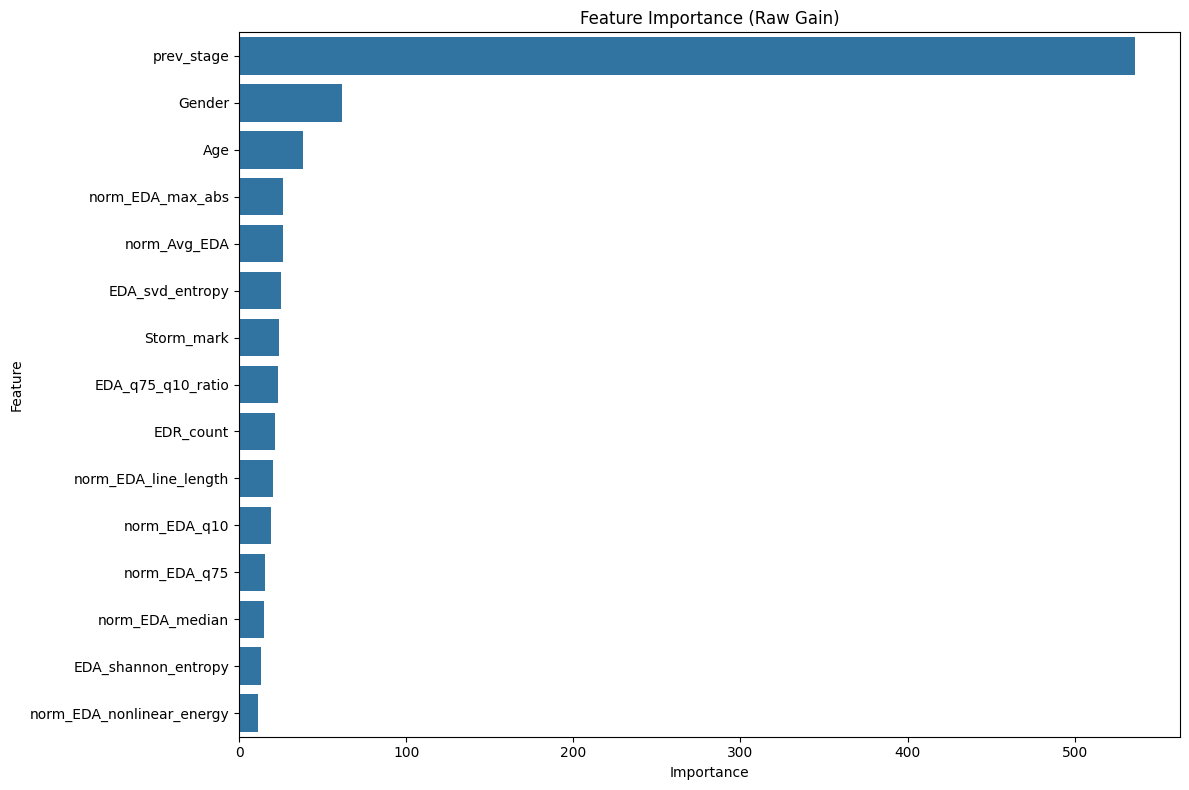

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1

Detailed Classification Report (Merged N2/N3):
              precision    recall  f1-score   support

           1     0.2081    0.5291    0.2987       669
         2/3     0.9179    0.8075    0.8592      4987
           R     0.9061    0.9136    0.9098      2060
           W     0.7951    0.5446    0.6464      1425

    accuracy                         0.7700      9141
   macro avg     0.7068    0.6987    0.6785      9141
weighted avg     0.8442    0.7700    0.7964      9141



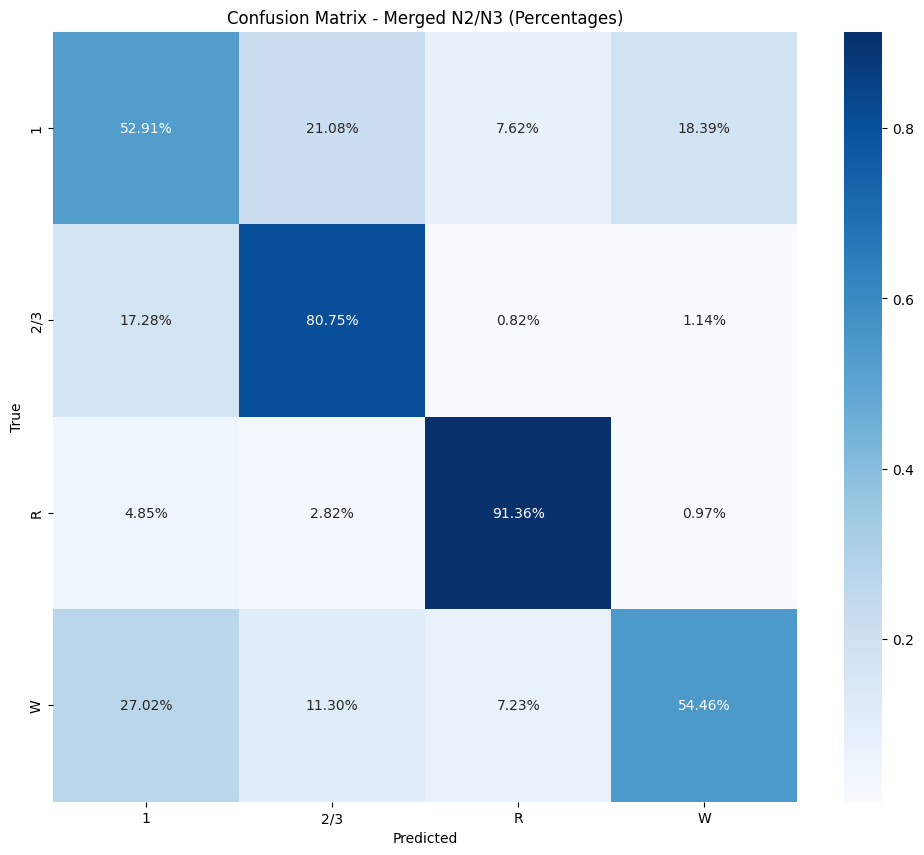

In [14]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from imblearn.over_sampling import SMOTE
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import xgboost as xgb
import lightgbm as lgb
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
from collections import Counter
import joblib
from sklearn.preprocessing import StandardScaler

# 1. Enhanced Data Loading with NaN Handling
def load_and_preprocess_data(features_dir):
    """Load and combine all feature files with proper patient IDs and label handling"""
    feature_files = glob.glob(os.path.join(features_dir, "Features_P*.csv"))
    dfs = []
    
    for file in feature_files:
        df = pd.read_csv(file)
        patient_id = int(os.path.basename(file).split('_')[1][1:])
        df['patient_id'] = patient_id
        df['Sleep_stage'] = df['Sleep_stage'].replace({'r': 'R'}).astype(str)
        dfs.append(df)
    
    combined_df = pd.concat(dfs, ignore_index=True)
    combined_df.replace([np.inf, -np.inf], np.nan, inplace=True)

    # Drop rows with any NaN values
    combined_df = combined_df.dropna()
    
    return combined_df

# 2. Robust Feature Engineering with N1-Specific Features
def normalize_by_subject(df):
    """Normalize features within each subject with robust handling"""
    features_to_normalize = [
        'Avg_EDA', 'EDA_median', 'EDA_max_abs', 'EDA_q10', 'EDA_q75',
        'EDA_line_length', 'EDA_nonlinear_energy'
    ]
    
    for feat in features_to_normalize:
        df[f'norm_{feat}'] = df.groupby('patient_id')[feat].transform(
lambda x: (x - x.median()) / (x.quantile(0.75) - x.quantile(0.25) + 1e-8))
    return df

def add_n1_specific_features(df):
    """Features known to help discriminate N1"""
    # N1 often has characteristic EDA patterns
    df['N1_EDA_pattern'] = ((df['norm_EDA_median'] > 0.5) & (df['norm_EDA_q75'] < 0.2))
    df['N1_EDA_pattern'] = df['N1_EDA_pattern'].astype(int)
    
    # Ratio features that help identify N1
    df['EDA_q75_q10_ratio'] = df['EDA_q75'] / (df['EDA_q10'] + 1e-8)
    return df

def add_temporal_features(df):
    """Add temporal features with proper label encoding"""
    df = df.sort_values(['patient_id', 'Epoch_duration'])
    le = LabelEncoder()
    all_stages = pd.concat([df['Sleep_stage'], df['Sleep_stage'].shift(1)])
    le.fit(all_stages.dropna().unique())
    df['prev_stage'] = le.transform(df.groupby('patient_id')['Sleep_stage'].shift(1).fillna('W'))
    return df, le

def handle_missing_values(df, target_col=None):
    """Advanced missing value imputation"""
    if target_col and target_col in df.columns:
        target = df[target_col]
        features = df.drop(columns=[target_col])
    else:
        features = df.copy()
    
    imputer = IterativeImputer(max_iter=10, random_state=42)
    imputed_features = imputer.fit_transform(features)
    imputed_df = pd.DataFrame(imputed_features, columns=features.columns)
    
    if target_col and target_col in df.columns:
        imputed_df[target_col] = target.values
    return imputed_df

def merge_n2_n3_stages(y_true, y_pred, le):
    """Merge N2 and N3 stages in the results"""
    stage_names = le.inverse_transform(range(len(le.classes_)))
    n2_idx = np.where(stage_names == '2')[0][0]
    n3_idx = np.where(stage_names == '3')[0][0]
    
    y_true_merged = np.where(y_true == n3_idx, n2_idx, y_true)
    y_pred_merged = np.where(y_pred == n3_idx, n2_idx, y_pred)
    
    merged_classes = [c for c in stage_names if c != '3']
    merged_classes[merged_classes.index('2')] = '2/3'
    return y_true_merged, y_pred_merged, merged_classes

# 3. N1-Focused Model Training
class N1FocusedEnsemble:
    """Custom ensemble that boosts N1 predictions"""
    def __init__(self, models, le, n1_index, boost_factor=2):
        self.models = models
        self.le = le
        self.n1_index = n1_index
        self.boost_factor = boost_factor
        
    def predict_proba(self, X):
        probas = [model.predict_proba(X) for model in self.models]
        avg_proba = np.mean(probas, axis=0)
        
        # Boost N1 probabilities
        avg_proba[:, self.n1_index] *= self.boost_factor
        # Renormalize
        return avg_proba / avg_proba.sum(axis=1)[:, np.newaxis]
        
    def predict(self, X):
        return np.argmax(self.predict_proba(X), axis=1)

def train_evaluate_model(X, y, le):
    # 1. PROPER DATA SPLITTING FIRST
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    # 2. MISSING VALUE IMPUTATION (after split!)
    imputer = IterativeImputer(max_iter=10, random_state=42)
    X_train = imputer.fit_transform(X_train)
    X_test = imputer.transform(X_test)

    # 3. SCALING
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # 4. APPLY SMOTE AFTER CLEANING
    try:
        smote = SMOTE(sampling_strategy='auto', random_state=42)
        X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
        print("SMOTE applied. New distribution:", Counter(y_train_res))
    except Exception as e:
        print(f"SMOTE failed: {e}. Using class weights only.")
        X_train_res, y_train_res = X_train, y_train
    
    # 4. BALANCED MODEL PARAMETERS
    xgb_params = {
        'objective': 'multi:softprob',
        'num_class': len(le.classes_),
        'max_depth': 4,
        'eta': 0.1,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'min_child_weight': 3,
        'eval_metric': ['mlogloss', 'merror'],
        'seed': 42
    }


    lgb_params = {
        'objective': 'multiclass',
        'num_class': len(le.classes_),
        'learning_rate': 0.05,
        'num_leaves': 31,
        'feature_fraction': 0.8,
        'min_data_in_leaf': 20,
        'lambda_l1': 0.1,
        'lambda_l2': 0.1
    }

    # 5. MORE CONSERVATIVE ENSEMBLE
    models = [
        ('xgb', xgb.XGBClassifier(**xgb_params)),
        ('lgbm', lgb.LGBMClassifier(**lgb_params)),
        ('rf', RandomForestClassifier(
            n_estimators=100,
            max_depth=5,
            class_weight='balanced',
            random_state=42
        ))
    ]
    
    base_ensemble = VotingClassifier(models, voting='soft')
    base_ensemble.fit(X_train_res, y_train_res)

    # Get the XGBoost model from the ensemble (before wrapping)
    xgb_model = base_ensemble.named_estimators_['xgb']
    booster = xgb_model.get_booster()
    importance = booster.get_score(importance_type='gain')
    mapped_importance = {
        feature_columns[int(f[1:])]: score for f, score in importance.items()
    }
    importance_df = pd.DataFrame({
        'Feature': list(mapped_importance.keys()),
        'Importance': list(mapped_importance.values())
    }).sort_values('Importance', ascending=False)

    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=importance_df.head(20))
    plt.title('Feature Importance (Raw Gain)')
    plt.tight_layout()
    plt.show()

    # Now wrap for N1 boosting
    n1_index = np.where(le.classes_ == '1')[0][0]
    ensemble = N1FocusedEnsemble([base_ensemble], le, n1_index=n1_index, boost_factor=2)

    # Evaluation
    y_pred = ensemble.predict(X_test)


    
    # Merged N2/N3 evaluation
    y_test_merged, y_pred_merged, merged_classes = merge_n2_n3_stages(y_test, y_pred, le)
    print("\nDetailed Classification Report (Merged N2/N3):")
    print(classification_report(y_test_merged, y_pred_merged, target_names=merged_classes, digits=4))
    
    # Confusion Matrix
    cm = confusion_matrix(y_test_merged, y_pred_merged)
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm_percent, annot=True, fmt='.2%', cmap='Blues',
                xticklabels=merged_classes, yticklabels=merged_classes)
    plt.title('Confusion Matrix - Merged N2/N3 (Percentages)')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    
    return ensemble

# Main Execution
if __name__ == "__main__":
    print("Loading and preprocessing data...")
    data = load_and_preprocess_data(
        r"C:\Users\LENOVO\OneDrive - American University of Beirut\FYP 2024-25 ECE\FYP_Fall_2024-2025\ML Implementation\XGBOOST_first_try\Features_with_entropy"
    )
    
    print("Engineering features...")
    data = normalize_by_subject(data)
    data = add_n1_specific_features(data)
    data, le = add_temporal_features(data)
    data['Sleep_stage'] = le.transform(data['Sleep_stage'])
    
    # Feature selection
    feature_columns = [
        'norm_Avg_EDA', 'norm_EDA_median', 'norm_EDA_max_abs',
        'norm_EDA_q10', 'norm_EDA_q75', 'norm_EDA_line_length',
        'norm_EDA_nonlinear_energy', 'EDA_svd_entropy',
        'EDA_shannon_entropy', 'EDR_count', 'Storm_mark',
        'Age', 'Gender', 'prev_stage', 'N1_EDA_pattern',
        'EDA_q75_q10_ratio'
    ]
    
    X = data[feature_columns]
    y = data['Sleep_stage']
    
    print("\nTraining model with N1-focused enhancements...")
    ensemble = train_evaluate_model(X, y, le)
    
    # joblib.dump(ensemble, 'n1_optimized_sleep_model.pkl')
    # print("\nOptimized model saved to 'n1_optimized_sleep_model.pkl'")